In [2]:
!pip install torch torchvision timm albumentations captum matplotlib opencv-python

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# Cell 2A
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git
DATA_DIR = 'PlantVillage-Dataset/raw/color'


fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [4]:
# 1) Try upgrading to a NumPy 2.x build (which restores numpy.strings):
%pip install numpy==2.0.2


  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.2 which is incompatible.


In [5]:
# Cell 3: define the dataset in‑notebook
import os, cv2
from torch.utils.data import Dataset
import albumentations as A

class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform or A.Compose([
            A.Resize(224,224), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast()
        ])
        self.samples = []
        for lbl in sorted(os.listdir(root_dir)):
            for img in os.listdir(f"{root_dir}/{lbl}"):
                self.samples.append((f"{root_dir}/{lbl}/{img}", lbl))
        self.label2idx = {l:i for i,l in enumerate(sorted({lbl for _,lbl in self.samples}))}

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p, lbl = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        img = img.transpose(2,0,1)/255.0
        return img.astype('float32'), self.label2idx[lbl]

        return img.astype('float32'), self.label2idx[lbl]


In [6]:
# show full tree under raw/color
!find PlantVillage-Dataset/raw/color -maxdepth 2 -type d | sed 's/\.\///g'


PlantVillage-Dataset/raw/color
PlantVillage-Dataset/raw/color/Potato___healthy
PlantVillage-Dataset/raw/color/Pepper,_bell___healthy
PlantVillage-Dataset/raw/color/Tomato___Spider_mites Two-spotted_spider_mite
PlantVillage-Dataset/raw/color/Peach___healthy
PlantVillage-Dataset/raw/color/Tomato___Tomato_mosaic_virus
PlantVillage-Dataset/raw/color/Blueberry___healthy
PlantVillage-Dataset/raw/color/Corn_(maize)___Northern_Leaf_Blight
PlantVillage-Dataset/raw/color/Grape___healthy
PlantVillage-Dataset/raw/color/Cherry_(including_sour)___Powdery_mildew
PlantVillage-Dataset/raw/color/Corn_(maize)___Common_rust_
PlantVillage-Dataset/raw/color/Grape___Esca_(Black_Measles)
PlantVillage-Dataset/raw/color/Corn_(maize)___healthy
PlantVillage-Dataset/raw/color/Soybean___healthy
PlantVillage-Dataset/raw/color/Apple___Cedar_apple_rust
PlantVillage-Dataset/raw/color/Tomato___Target_Spot
PlantVillage-Dataset/raw/color/Tomato___healthy
PlantVillage-Dataset/raw/color/Pepper,_bell___Bacterial_spot
PlantVi

In [7]:
from sklearn.model_selection import train_test_split
import os

DATA_DIR = 'PlantVillage-Dataset/raw/color'

# 1) Gather all (path, label) pairs:
all_samples = []
for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_path): continue
    for img in os.listdir(cls_path):
        all_samples.append((os.path.join(cls_path, img), cls))

# 2) Stratified split 80/20:
paths, labels = zip(*all_samples)
train_idxs, val_idxs = train_test_split(
    range(len(all_samples)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)
train_samples = [all_samples[i] for i in train_idxs]
val_samples   = [all_samples[i] for i in val_idxs]


In [8]:
import cv2
import albumentations as A
from torch.utils.data import Dataset

class ListDataset(Dataset):
    def __init__(self, samples, transform=None):
        # samples: list of (full_image_path, label_str)
        self.samples = samples
        self.transform = transform or A.Compose([
            A.Resize(224,224), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast()
        ])
        # build label → int map
        labels = sorted({lbl for _,lbl in samples})
        self.label2idx = {lbl:i for i,lbl in enumerate(labels)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        img = img.transpose(2,0,1) / 255.0
        return img.astype('float32'), self.label2idx[lbl]


In [9]:
from torch.utils.data import DataLoader

train_ds = ListDataset(train_samples)
val_ds   = ListDataset(val_samples)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

# Quick sanity check:
print("Train batches:", len(train_loader), " — Val batches:", len(val_loader))
imgs, lbls = next(iter(train_loader))
print("Batch shape:", imgs.shape, "  Labels:", lbls[:5])


Train batches: 1358  — Val batches: 340
Batch shape: torch.Size([32, 3, 224, 224])   Labels: tensor([31, 25, 21, 24,  4])


In [12]:
# Cell 8: Baseline train for 3 epochs & validate
import torch
import timm                    # ← add this
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Assuming train_loader & val_loader are already defined from previous cells
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build model
model = timm.create_model('resnet50', pretrained=True, num_classes=len(train_ds.label2idx))
# Freeze all except classifier
for p in model.parameters():
    p.requires_grad = False
for p in model.get_classifier().parameters():
    p.requires_grad = True
model = model.to(device)

# Optimizer & loss
opt = Adam(model.get_classifier().parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

# Train + validate loop
for epoch in range(1, 4):
    model.train()
    running_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        loss = crit(model(imgs), lbls)
        loss.backward()
        opt.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            truths.extend(lbls.cpu().numpy())
    acc = accuracy_score(truths, preds)
    print(f"Epoch {epoch} → Train Loss: {epoch_loss:.4f}  Val Acc: {acc:.4f}")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1 → Train Loss: 1.1952  Val Acc: 0.9001
Epoch 2 → Train Loss: 0.4554  Val Acc: 0.9254
Epoch 3 → Train Loss: 0.3202  Val Acc: 0.9393


In [13]:
# Cell 9: Unfreeze layer4 & classifier, lower LR, train further
for name, p in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        p.requires_grad = True

opt = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Continue training for 3–5 more epochs
for epoch in range(4, 8):
    model.train()
    total_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        loss = crit(model(imgs), lbls)
        loss.backward()
        opt.step()
        total_loss += loss.item() * imgs.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    # Validation
    model.eval()
    p, t = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            p.extend(torch.argmax(out,1).cpu().numpy())
            t.extend(lbls.cpu().numpy())
    acc = accuracy_score(t, p)
    print(f"Epoch {epoch} → Train Loss: {train_loss:.4f}  Val Acc: {acc:.4f}")


Epoch 4 → Train Loss: 0.1529  Val Acc: 0.9695
Epoch 5 → Train Loss: 0.0819  Val Acc: 0.9770
Epoch 6 → Train Loss: 0.0541  Val Acc: 0.9809
Epoch 7 → Train Loss: 0.0362  Val Acc: 0.9827


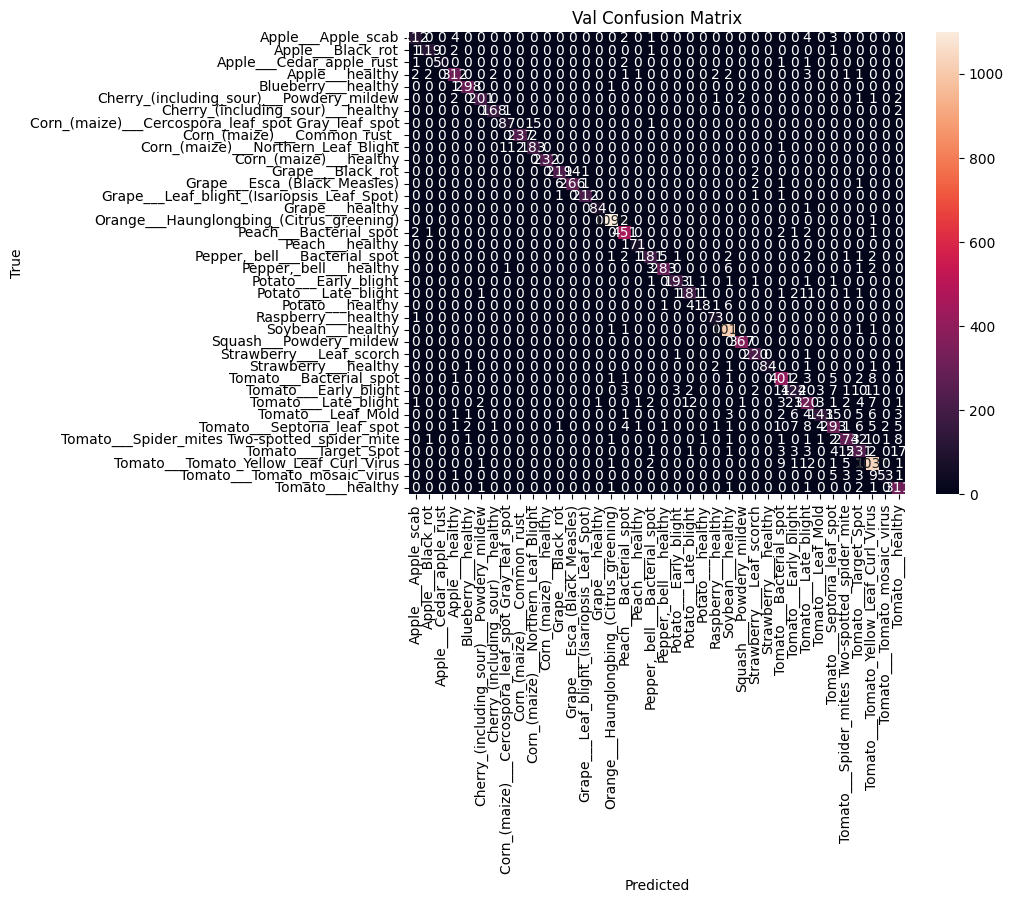

In [14]:
# Cell 10: Compute & display confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns  # only for plotting here

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_ds.label2idx.keys(),
            yticklabels=train_ds.label2idx.keys())
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Val Confusion Matrix')
plt.show()


In [16]:
# Cell 11: Initialize Grad‑CAM correctly
from captum.attr import LayerGradCam
from torchvision import transforms
from PIL import Image

# pass the layer itself as the 2nd argument
gradcam = LayerGradCam(model, model.layer4[-1])

prep = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])



True label: Cherry_(including_sour)___healthy


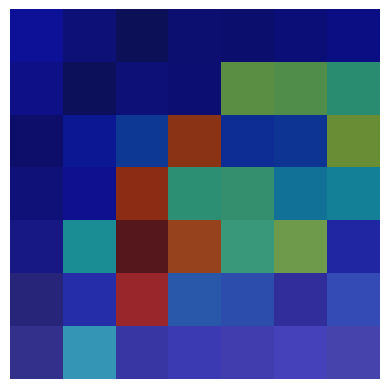

True label: Tomato___Target_Spot


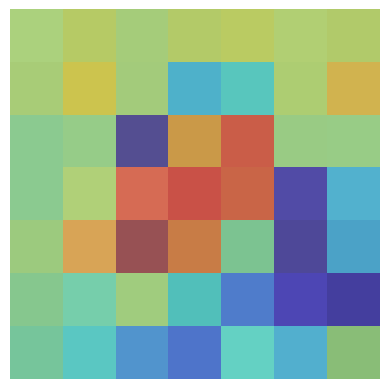

True label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


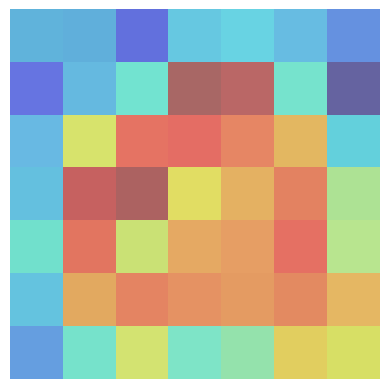

In [17]:
# Cell 12: Show 3 random validation samples with CAM overlays
import random

def show_cam(img_path, idx):
    inp = prep(Image.open(img_path)).unsqueeze(0).to(device)
    mask = gradcam.attribute(inp, target=idx).squeeze().cpu().detach().numpy()
    plt.figure(); plt.imshow(Image.open(img_path)); plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.axis('off'); plt.show()

samples = random.sample(val_samples, 3)
for path, lbl in samples:
    idx = train_ds.label2idx[lbl]
    print("True label:", lbl)
    show_cam(path, idx)
